In [108]:
# Model design
import agentpy as ap

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython

import random

start_x, end_x = 0, 50
y_position = 25
horizontal_positions = [(x, y_position) for x in range(start_x, end_x)]
vertical_positions = [(25, x) for x in range(start_x, end_x)]
positions = horizontal_positions + vertical_positions


random_goal_position = random.choice(positions)
print("random_goal_position : ", random_goal_position)

class MovingAgent(ap.Agent):
    def setup(self):
        self.position = (25, 0)  # Starting position
        self.goal = random_goal_position    # Goal position
        self.path = positions
        # self.condition = 1

    def move(self):
        # Define movement logic here to move towards the goal
        # Ensure movement is within allowed positions
        # If goal is reached, stop the model
        if self.position == self.goal:
            self.model.stop()
        else:
            # Example movement: move closer to the goal
            x, y = self.position
            goal_x, goal_y = self.goal

            # Move in the x direction
            if x < goal_x and (x + 1, y) in self.path:
                x += 1
            elif x > goal_x and (x - 1, y) in self.path:
                x -= 1

            # Move in the y direction
            if y < goal_y and (x, y + 1) in self.path:
                y += 1
            elif y > goal_y and (x, y - 1) in self.path:
                y -= 1

            self.position = (x, y)

#! specific position on the grid, you should use self.forest.agents[position]
#* คอมเมนท์สีเขียวหมายความว่าเคยใช้งาน แต่เอาออกไปแล้ว
#TODO คอมเมนท์สีส้มคือ ทำภายในอนาคต
#? คอมเมนท์สีฟ้าเอาไว้บอกส่วนสำคัญเฉยๆ
# คอมเมนท์สีเทา ไว้อธิบายเฉย

def manhattan_distance(point1, point2):
    return abs(point1[0] - point2[0]) + abs(point1[1] - point2[1])


class Road(ap.Agent):
    def setup(self):
        # `position` เป็นคุณสมบัติของเอเยนต์
        self.position = None


class ForestModel(ap.Model):

    def setup(self):

        # Create agents (trees)
        #* n_trees = int(self.p['Tree density'] * (self.p.size**2))
        n_trees = 100
        roads = self.roads = ap.AgentList(self, n_trees , Road) # สร้างตัวแทน n_trees ตัว



        # Create grid (forest) สร้างกริดขนาด 50*50
        self.map = ap.Grid(self, [self.p.size]*2, track_empty=True) # https://agentpy.readthedocs.io/en/latest/reference_grid.html#agentpy.Grid
        # ต้นไม้มี 1500 พื้นที่ทั้งหมดบนแมพมี 2500 (50*50)


        # TODO ทำ Position
        # position เป็น array --> [(0, 25), (1, 25) , ...] 
        # เอาไว้ให้รู้ว่า ถ้าอยากฟิกตำแหน่ง agent ตัวที่ 50 มันทำไง
        # positions = [(i % 50, i // 50) for i in range(2500)]
        # positions[50] = (2, 8)


        self.map.add_agents(roads, positions=positions, empty=True) # https://agentpy.readthedocs.io/en/latest/reference_environments.html

        #? Initialize conditions 
        self.roads.condition = 0
        # condition เป็นค่าที่คุณกำหนดให้เฉพาะกลุ่มของเอเยนต์ 
        # condition ของเอเยนต์ทั้งหมดใน self.roads เป็น 0 แต่ถ้าเอเยนต์ใดไม่ได้อยู่ใน self.roads มันจะมีค่า None




        #? Define positions
        # self.positions = positions
        self.map.add_agents(roads, positions=positions, empty=True) # add Road Agent
        for road, pos in zip(self.roads, positions):
            road.position = pos
            # -->  Road (Obj 1) pos : (0, 25)
        # for agent in self.map.agents:
        #     print(f"agent {agent.position} condition : {agent.condition}")
        # agent (0, 25) condition : 0


        #? Define function to get agents at specific positions
        # def get_agents_at_position(grid, position):
        #     return [agent for agent in grid.agents if grid.positions[agent] == position]

        
        #? Create a MovingAgent 
        bicycle = self.bicycle = ap.AgentList(self, 1, MovingAgent)
        self.map.add_agents(bicycle, positions=bicycle.position)
        self.bicycle.condition = 3

        
        #? Set Goal
        reachTarget = self.map.agents[random_goal_position]  # Access agents at position (10, 25)
        # reachTarget เป็น GridIter 
        print(f"reachTarget: {reachTarget}")
        if reachTarget:  # Check if any agents exist at that position
            for agent in reachTarget:  # Loop through agents and update condition
                print(f"agent : {agent}")
                if isinstance(agent, Road):
                    agent.condition = 4
        else:
            print("No agent found at (10, 25)")

        # reachTarget: GridIter (2 objects)
        # agent : Road (Obj 51)
        # agent : MovingAgent (Obj 102)


        # print("self.map.agents : ",  self.map.agents) # GridIter (101 objects)

        

        print("----------------------- end setup")

        

    def step(self):

        # Select burning trees
        #* burning_trees = self.agents.select(self.agents.condition == 1) # มี AgentList (0 objects) ที่ได้งี้ เพราะเราไม่ใส่ condition 1 ลงไป
        # for tree in burning_trees:
        #     for neighbor in self.forest.neighbors(tree):

        

        # class AgentList ทั้งสองตัว
        find_bike = self.bicycle.select(self.bicycle.condition == 3) # มี AgentList (1 object)
        start = self.roads.select(self.roads.position == find_bike.position[0])  # Find the starting position
        all_path = []
        # print(f" find_bike.position : {find_bike.position}")
        for gridRoad in start:
            # gridRoad class Road
            for neighbor in self.map.neighbors(gridRoad):
                all_path.append(neighbor.position)
                # print(neighbor.position) มี 2 ตัวคือ (25,0) and (25,1)
                # if neighbor.position == gridRoad.position:
                #     continue
                # else:
                #     # self.map.move_by(find_bike, neighbor.position)
                #     self.bicycle[0].position = neighbor.position
                #     print(f" find_bike.position หลัง move : {find_bike.position}")
                #     break; # breakเพราะเพื่อนบ้านมีหลายอัน แต่เราต้องการอันเดียวแล้วจบเลย
        
        
        closest_path = None
        min_distance = float('inf')  # กำหนดค่าระยะทางขั้นต่ำเริ่มต้นเป็นอนันต์
        # print(all_path) # [(25, 0), (25, 1)]
        for path in all_path:
            distance = manhattan_distance(path, random_goal_position)
            if distance < min_distance:
                min_distance = distance
                closest_path = path
                # print(f"The closest path to {random_goal_position} is {closest_path} with a distance of {min_distance}.")

        self.bicycle[0].position = closest_path
        # self.map.move_by(self.bicycle[0], (25,25))
        print(f"time: {self.t} , closest_path {closest_path} , self.bicycle[0] : {self.bicycle[0].position}")
        if (25, 25) in self.map.empty:
            self.map.move_by(self.bicycle[0], (25, 25))
        else:
            print(f"Cannot move to (25, 25): Occupied by another agent or not valid.")
        agents_at_target = [agent for agent in self.map.agents if agent.position == (25, 25)]
        print(f"Agents at (25, 25): {agents_at_target}")
        
        
        # Concept
        # for ตำแหน่งจุดหนึ่งที่มีจักรยานอยู่gridRoad(Agent) in ถนนทั้งหมดRoads(AgentList)
        #     for เพื่อนบ้านของตำแหน่งกริดถนนที่มีจักรยานอยู่ in เพื่อนบ้านของgridRoad(AgentIter)
        #         # มันจะมีเพื่อนบ้าน 4 ทิศ เขียนเงื่อนไข
        #         ถ้าเป็นตำแหน่งตัวเอง:
        #             continue
        #         moving
            
            


        


        if self.t == 10:
            self.stop()


       
        
        




    def end(self):

        # Document a measure at the end of the simulation
        # burned_trees = len(self.agents.select(self.agents.condition == 2))
        # self.report('Percentage of burned trees',
        #             burned_trees / len(self.agents))
        self.report("Bicycle Sharing")

        
        
parameters = {
    'Tree density': 0.2, # Percentage of grid covered by trees
    'size': 50, # Height and length of the grid
    'steps': 100,
}

# Create single-run animation with custom colors

def animation_plot(model, ax):
    attr_grid = model.map.attr_grid('condition') # attr_grid() เป็นฟังก์ชันที่ใช้เรียกค่าแอตทริบิวต์ (attribute) ของตัวแทนทั้งหมดในพื้นที่ grid ของป่า
    # ฟังก์ชันด้านบน attr_grid ด้านบน จะสร้าง grid (ตารางหรือแผนที่) ของป่าที่แสดงสถานะของตัวแทน (agents) ทุกตัว โดยดึงข้อมูลจากแอตทริบิวต์ condition ของแต่ละตัวแทนและจัดเรียงเป็นรูปแบบ grid
    # A two-dimensional grid (กริดสองมิติ) คือโครงสร้างข้อมูลที่ใช้ในการจัดระเบียบข้อมูลหรือวัตถุต่างๆ ลงในรูปแบบของตารางที่มีสองมิติ—มิติแถวและมิติคอลัมน์ โดยทั่วไปแล้วจะมีลักษณะเป็นตารางที่แบ่งออกเป็นเซลล์ (cells) ที่แต่ละเซลล์สามารถเก็บข้อมูลหรือวัตถุได้
    
    # 0 คือ เริ่มต้น น้ำเงินนนน คือถนน ,1 คือถนน ดำำำ,  2 คือเป็นที่ที่เดินแล้ว ชมพู , None คือสีน้ำตาล ,3 คือ actor or bicycle , 4 คือ goal , '#d5e5d5' หรือ None อันก่อนเป็นพื้นที่ที่ไม่ใช่ถนน
    color_dict = {0:'#0000FF',  2:'#ff00fb', None:'#402b2f' , 3:"#aa7eee", 4:'#ffeb00'}
    ap.gridplot(attr_grid, ax=ax, color_dict=color_dict, convert=True) # https://agentpy.readthedocs.io/en/latest/reference_visualization.html
    ax.set_title(f"Simulation\n"
                 f"Time-step: {model.t}"
                #  f"Trees left: {len(model.agents.select(model.agents.condition == 0))}"
                )

fig, ax = plt.subplots()
model = ForestModel(parameters)
animation = ap.animate(model, fig, ax, animation_plot)
IPython.display.HTML(animation.to_jshtml(fps=15))


random_goal_position :  (28, 25)
reachTarget: GridIter (1 object)
agent : Road (Obj 29)
----------------------- end setup
time: 1 , closest_path (25, 1) , self.bicycle[0] : (25, 1)
Cannot move to (25, 25): Occupied by another agent or not valid.
Agents at (25, 25): [Road (Obj 26), Road (Obj 76)]
time: 2 , closest_path (25, 2) , self.bicycle[0] : (25, 2)
Cannot move to (25, 25): Occupied by another agent or not valid.
Agents at (25, 25): [Road (Obj 26), Road (Obj 76)]
time: 3 , closest_path (25, 3) , self.bicycle[0] : (25, 3)
Cannot move to (25, 25): Occupied by another agent or not valid.
Agents at (25, 25): [Road (Obj 26), Road (Obj 76)]
time: 4 , closest_path (25, 4) , self.bicycle[0] : (25, 4)
Cannot move to (25, 25): Occupied by another agent or not valid.
Agents at (25, 25): [Road (Obj 26), Road (Obj 76)]
time: 5 , closest_path (25, 5) , self.bicycle[0] : (25, 5)
Cannot move to (25, 25): Occupied by another agent or not valid.
Agents at (25, 25): [Road (Obj 26), Road (Obj 76)]
tim

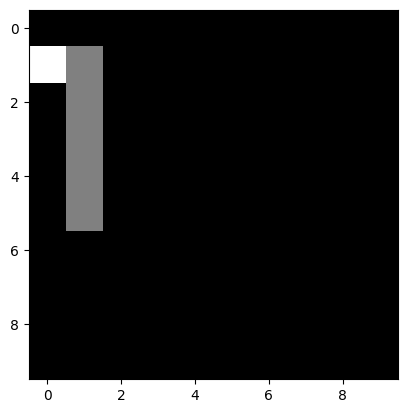

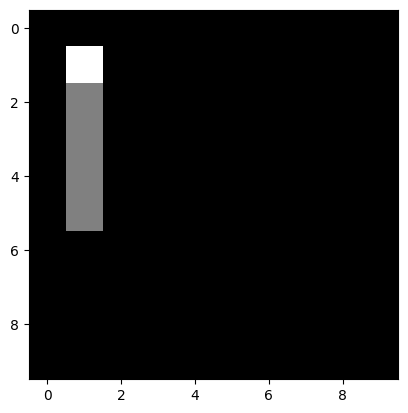

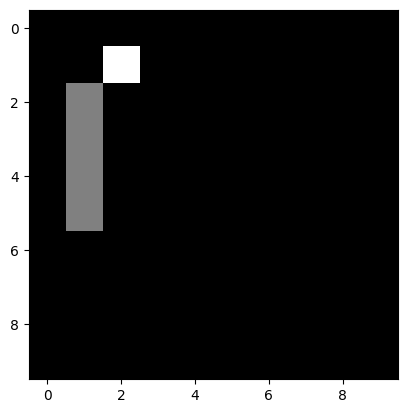

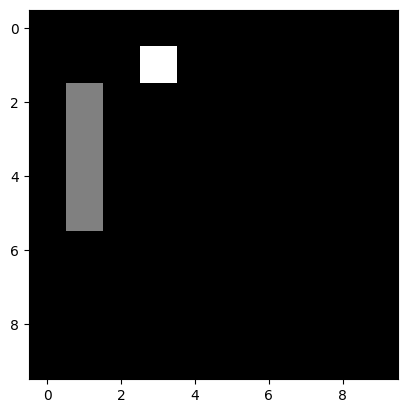

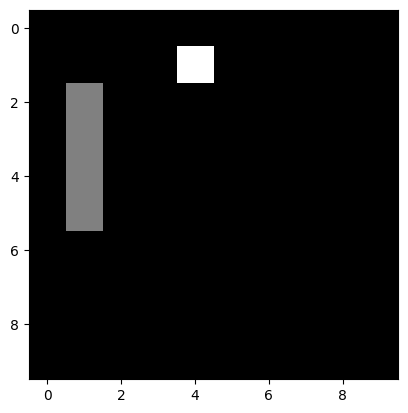

In [109]:
import numpy as np
import matplotlib.pyplot as plt

class Grid:
    def __init__(self, width, height):
        self.grid = np.zeros((height, width))  # 0: empty, 1: road
        self.bicycles = []  # List of bicycles in the grid

    def add_road(self, road_positions):
        for pos in road_positions:
            self.grid[pos[1], pos[0]] = 1  # Mark road

    def add_bicycle(self, position):
        self.bicycles.append(position)
        self.grid[position[1], position[0]] = 2  # Mark bicycle

    def move_bicycle(self, old_position, new_position):
        if self.is_valid_move(new_position):
            self.grid[old_position[1], old_position[0]] = 0  # Clear old position
            self.grid[new_position[1], new_position[0]] = 2  # Set new position
            self.bicycles[self.bicycles.index(old_position)] = new_position  # Update bicycle position

    def is_valid_move(self, position):
        # Check boundaries and if the cell is a road
        return (0 <= position[0] < self.grid.shape[1] and 
                0 <= position[1] < self.grid.shape[0] and 
                self.grid[position[1], position[0]] != 2)  # Cannot move to another bicycle

    def display(self):
        plt.imshow(self.grid, cmap='gray', interpolation='nearest')
        plt.show()


class Bicycle:
    def __init__(self, grid, start_position):
        self.grid = grid
        self.position = start_position
        self.grid.add_bicycle(start_position)

    def move(self, new_position):
        self.grid.move_bicycle(self.position, new_position)
        self.position = new_position

# Example usage
grid = Grid(10, 10)
grid.add_road([(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)])  # Adding a road
bicycle = Bicycle(grid, (0, 0))  # Initial bicycle position

# Move bicycle
for step in range(5):
    bicycle.move((step, 1))  # Move along the road
    grid.display()  # Show the grid after each move


TypeError: attribute name must be string, not 'int'

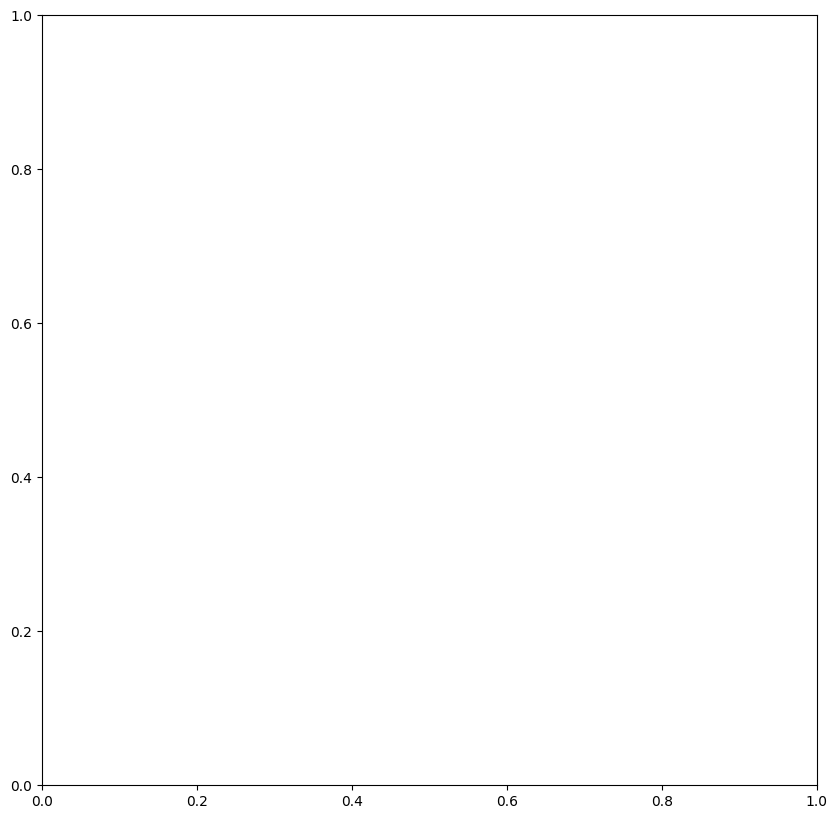

In [13]:
import agentpy as ap
import matplotlib.pyplot as plt
import random

class Bicycle(ap.Agent):
    def setup(self):
        self.position = None
        self.in_use = False

class User(ap.Agent):
    def setup(self):
        self.position = None
        self.has_bicycle = False
        self.destination = None

class BicycleSharingModel(ap.Model):
    def setup(self):
        self.size = self.p.size
        self.grid = ap.Grid(self, [self.size, self.size], track_empty=True)
        
        # Create bicycle stations
        # station_positions = [self.grid.positions[pos] for pos in [(10, 10), (30, 30), (10, 40), (40, 10)]]
        station_positions = [(10, 10), (30, 30), (10, 40), (40, 10)]
        self.stations = set(station_positions)
        
        # Create bicycles
        self.bicycles = ap.AgentList(self, self.p.n_bicycles, Bicycle)
        for bicycle in self.bicycles:
            pos = random.choice(station_positions)
            self.grid.add_agents(bicycle, pos)
            bicycle.position = pos
        
        # Create users
        self.users = ap.AgentList(self, self.p.n_users, User)
        for user in self.users:
            pos = random.choice(self.grid.empty)
            self.grid.add_agents(user, pos)
            user.position = pos
            user.destination = random.choice(station_positions)
        
        # Define valid paths
        self.valid_paths = set(self.grid.positions[x, y] for x in range(self.size) for y in range(self.size)
                               if x % 5 == 0 or y % 5 == 0)

    def step(self):
        for user in self.users:
            if not user.has_bicycle:
                # Try to pick up a bicycle
                bicycles_here = [b for b in self.bicycles if b.position == user.position and not b.in_use]
                if bicycles_here and user.position in self.stations:
                    bicycle = bicycles_here[0]
                    bicycle.in_use = True
                    user.has_bicycle = True
                else:
                    # Move towards nearest station
                    nearest_station = min(self.stations,
                        key=lambda p: abs(self.grid.positions[p][0] - self.grid.positions[user.position][0]) + 
                                      abs(self.grid.positions[p][1] - self.grid.positions[user.position][1])
                    )
                    self.move_agent(user, nearest_station)
            else:
                # Move towards destination
                self.move_agent(user, user.destination)
                
                # Check if destination reached
                if user.position == user.destination:
                    user.has_bicycle = False
                    for bicycle in self.bicycles:
                        if bicycle.position == user.position and bicycle.in_use:
                            bicycle.in_use = False
                            break
                    user.destination = random.choice(list(self.stations))

    def move_agent(self, agent, target):
        current_pos = self.grid.positions[agent.position]
        target_pos = self.grid.positions[target]
        possible_moves = [
            pos for pos in self.grid.neighbors(agent)
            if pos in self.valid_paths and (
                abs(self.grid.positions[pos][0] - target_pos[0]) < abs(current_pos[0] - target_pos[0]) or
                abs(self.grid.positions[pos][1] - target_pos[1]) < abs(current_pos[1] - target_pos[1])
            )
        ]
        if possible_moves:
            new_pos = min(possible_moves, 
                key=lambda p: abs(self.grid.positions[p][0] - target_pos[0]) + 
                              abs(self.grid.positions[p][1] - target_pos[1])
            )
            self.grid.move_agent(agent, new_pos)
            agent.position = new_pos

    def end(self):
        self.report("Bicycle Sharing Simulation Completed")

parameters = {
    'size': 50,
    'n_bicycles': 20,
    'n_users': 10,
    'steps': 100,
}

def animation_plot(model, ax):
    ax.clear()
    
    # Plot paths
    path_positions = [model.grid.positions[pos] for pos in model.valid_paths]
    path_x, path_y = zip(*path_positions)
    ax.scatter(path_x, path_y, c='#d3d3d3', marker='s', s=20)
    
    # Plot stations
    station_positions = [model.grid.positions[pos] for pos in model.stations]
    station_x, station_y = zip(*station_positions)
    ax.scatter(station_x, station_y, c='blue', marker='s', s=50)
    
    # Plot bicycles
    bicycle_positions = [model.grid.positions[b.position] for b in model.bicycles if b.position is not None]
    if bicycle_positions:
        bicycle_x, bicycle_y = zip(*bicycle_positions)
        ax.scatter(bicycle_x, bicycle_y, c='green', marker='o', s=30)
    
    # Plot users
    user_positions = [model.grid.positions[u.position] for u in model.users if u.position is not None]
    if user_positions:
        user_x, user_y = zip(*user_positions)
        ax.scatter(user_x, user_y, c='red', marker='^', s=30)
    
    ax.set_title(f"Bicycle Sharing Simulation\nTime-step: {model.t}")
    ax.set_xlim(0, model.size)
    ax.set_ylim(0, model.size)

# To run the simulation and create an animation:
model = BicycleSharingModel(parameters)
fig, ax = plt.subplots(figsize=(10, 10))
animation = ap.animate(model, fig, ax, animation_plot)
IPython.display.HTML(animation.to_jshtml(fps=5))

TypeError: attribute name must be string, not 'int'

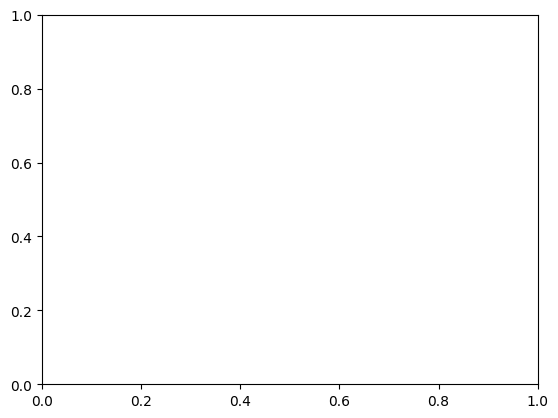

In [39]:
import agentpy as ap
import matplotlib.pyplot as plt
import IPython

class MovingAgent(ap.Agent):
    def setup(self):
        self.position = (0, 0)  # Starting position
        self.goal = (9, 9)  # Goal position
        self.condition = 3  # Assign a condition for visualization

    def move(self):
        x, y = self.position
        goal_x, goal_y = self.goal

        # Move towards goal in x direction
        if x < goal_x and (x + 1, y) in self.model.grid.empty:
            x += 1
        elif x > goal_x and (x - 1, y) in self.model.grid.empty:
            x -= 1

        # Move towards goal in y direction
        if y < goal_y and (x, y + 1) in self.model.grid.empty:
            y += 1
        elif y > goal_y and (x, y - 1) in self.model.grid.empty:
            y -= 1

        # Update position in the grid
        self.model.grid.set(self, (x, y))  # Use set to update position
        self.position = (x, y)

        if self.position == self.goal:
            self.model.stop()

class SimpleModel(ap.Model):
    def setup(self):
        self.grid = ap.Grid(self, [10, 10], track_empty=True)
        self.bicycle = MovingAgent(self)
        self.grid.add_agents(self.bicycle, positions=[self.bicycle.position])

    def step(self):
        self.bicycle.move()

def animation_plot(model, ax):
    attr_grid = model.grid.attr_grid('condition')  # Get the attribute grid using the key
    color_dict = {None: '#ffffff', 3: '#aa7eee'}  # Color for bicycle
    ap.gridplot(attr_grid, ax=ax, color_dict=color_dict, convert=True)
    ax.set_title(f"Time-step: {model.t}")

# Create and run the model
parameters = {
    'steps': 20,
}
model = SimpleModel(parameters)
fig, ax = plt.subplots()
animation = ap.animate(model, fig, ax, animation_plot)
IPython.display.HTML(animation.to_jshtml(fps=5))


In [41]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import folium 
import plotly.express as px 
import osmnx as ox 
import networkx as nx 
from ortools.constraint_solver import pywrapcp 
from ortools.constraint_solver import routing_enums_pb2



city = "London"
dtf=pd.read_csv('data_stores.csv')
dtf=dtf[dtf["City"]==city][ ["City", "Street Address", "Latitude", "Longitude"]].reset_index(drop=True)
dtf=dtf.reset_index().rename(columns={"index":"id", "Latitude":"y", "Longitude":"x"})

print("total", len(dtf))
dtf.head(3)

ModuleNotFoundError: No module named 'folium'